# **Experimenting with NFL Tracking Data, Contact Data. (Kaggle Competition)**

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Introduction

The NFL hosts data analysis competitions on Kaggle. This one in particular focuses on insights extractable from combining tracking data (locations, speeds, etc.), contact data (contact or no contact on play), and video data of the plays. 

In tandem with my Offensive Line projections project, I sought to conduct an analysis of this data. As explained in the projections project, I believe the offensive line to be the most pivotal position in football. I think that analyzing tracking and contact data can give valuable insight into predicting and preventing Offensive Line injuries.

I endeavored into some data merging and cleaning to ultimately create a Random Forest Model which predicts Offensive Line Contact, and then set out to build a computer vision model which identifies Offensive Line contact in video feed. 

I was confronted with memory issues which prevented me from converting video data from a play into an array of pixels, but I went throught the motions of building the computer vision model for possible future use.

## Reading Data (slice to preserve memory)

In [2]:
#train_baseline_helmets = pd.read_csv('train_baseline_helmets.csv')
#specific_rows = range(0,10000)
train_labels = pd.read_csv('train_labels.csv')
train_player_tracking = pd.read_csv('train_player_tracking.csv')
#train_video_metadata = pd.read_csv('train_video_metadata.csv')

Loading label data sorted by play

In [3]:
train_labels = train_labels.sort_values('game_play', ascending = True)[0:100000]

In [4]:
train_labels = train_labels.rename({'nfl_player_id_1':'nfl_player_id'}, axis=1)

In [5]:
train_labels.head()

,contact_id,game_play,datetime,step,nfl_player_id,nfl_player_id_2,contact
0,58168_003392_0_38590_43854,58168_003392,2020-09-11T03:01:48.100Z,0,38590,43854,0
11798,58168_003392_46_37084_46522,58168_003392,2020-09-11T03:01:52.700Z,46,37084,46522,0
11799,58168_003392_46_44869_47944,58168_003392,2020-09-11T03:01:52.700Z,46,44869,47944,0
11800,58168_003392_46_44869_47837,58168_003392,2020-09-11T03:01:52.700Z,46,44869,47837,0
11801,58168_003392_46_44869_46137,58168_003392,2020-09-11T03:01:52.700Z,46,44869,46137,0


Loading tracking data sorted by play

In [7]:
train_player_tracking = train_player_tracking.sort_values('game_play', ascending = True)[0:100000]

In [8]:
train_player_tracking.head()

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
1074656,58168_003392,58168,3392,43395,2020-09-11T03:01:34.800Z,-133,away,FS,23,48.18,26.19,1.24,0.13,15.28,312.43,0.46,-0.35
1076549,58168_003392,58168,3392,37084,2020-09-11T03:01:38.800Z,-93,away,DE,99,42.70,20.18,0.61,0.06,289.58,265.72,0.27,-0.26
1076550,58168_003392,58168,3392,43854,2020-09-11T03:01:38.800Z,-93,away,OLB,57,42.37,17.05,0.90,0.09,186.46,277.93,0.33,0.31
1076551,58168_003392,58168,3392,46137,2020-09-11T03:01:38.800Z,-93,away,SS,20,46.87,19.68,1.05,0.10,206.78,253.45,0.73,0.50
1076552,58168_003392,58168,3392,44869,2020-09-11T03:01:38.800Z,-93,away,ILB,41,48.45,22.63,0.53,0.05,227.04,272.64,0.63,0.57


Check what plays are labeled in my truncated dataset

In [9]:
train_labels.groupby('game_play').size()

game_play
58168_003392    17710
58172_003247    31878
58173_003606    32890
58174_001792    17522
dtype: int64

## Merge the Tracking Data and Label Data on the First Player id Involved in the Time Step:

In [11]:
track_labels = pd.merge(train_labels, train_player_tracking, on = ['game_play','datetime','nfl_player_id'], how = 'inner')

In [12]:
track_labels.groupby('play_id').size()

play_id
1792    17522
3247    31878
3392    17710
3606    32890
dtype: int64

In [13]:
track_labels.columns

Index(['contact_id', 'game_play', 'datetime', 'step_x', 'nfl_player_id',
       'nfl_player_id_2', 'contact', 'game_key', 'play_id', 'step_y', 'team',
       'position', 'jersey_number', 'x_position', 'y_position', 'speed',
       'distance', 'direction', 'orientation', 'acceleration', 'sa'],
      dtype='object')

Which Positions have are being tracked the most in my merged data set:

In [17]:
track_labels['position'].value_counts()

CB     10493
TE     10218
DE      9429
T       8849
ILB     8391
WR      6754
G       5551
RB      5472
OLB     4872
FS      4268
C       3322
LB      3264
DT      2921
SS      2814
DB      2650
QB      2270
MLB     2268
OG      1690
FB      1470
LS      1260
DL       780
P        504
OT       490
Name: position, dtype: int64

OTs dataset:

In [18]:
track_labels_OT = track_labels.query("position == 'T' or position =='OT'")
sum(track_labels_OT['contact']==0)

9149

## EDA with OTs Data

<AxesSubplot:xlabel='x_position', ylabel='orientation'>

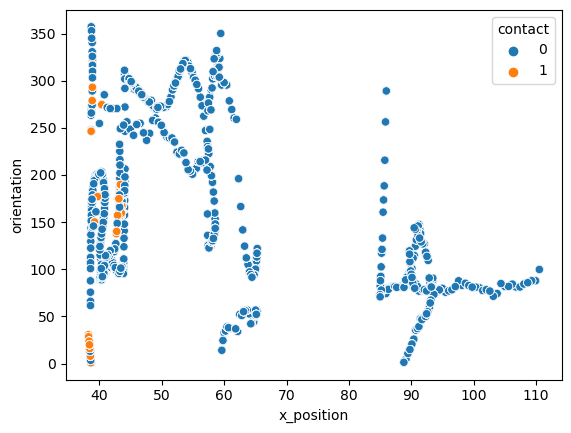

In [19]:
sns.scatterplot(data = track_labels_OT, x = 'x_position', y= 'orientation', hue = 'contact')

<AxesSubplot:xlabel='speed', ylabel='orientation'>

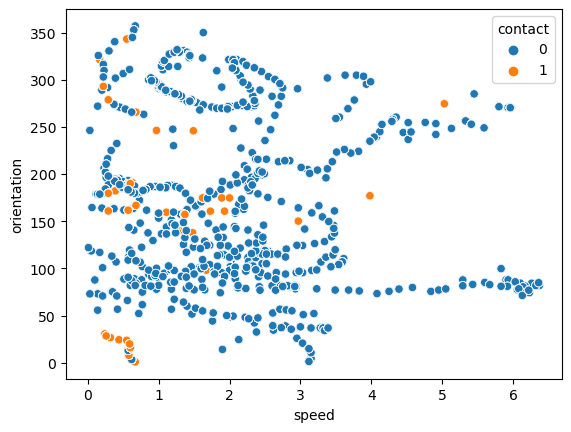

In [20]:
sns.scatterplot(data = track_labels_OT, x = 'speed', y= 'orientation', hue = 'contact')

<AxesSubplot:xlabel='distance', ylabel='orientation'>

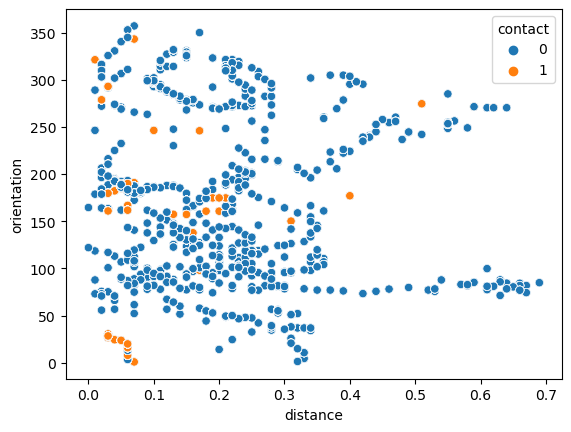

In [21]:
sns.scatterplot(data = track_labels_OT, x = 'distance', y= 'orientation', hue = 'contact')

<AxesSubplot:xlabel='acceleration', ylabel='orientation'>

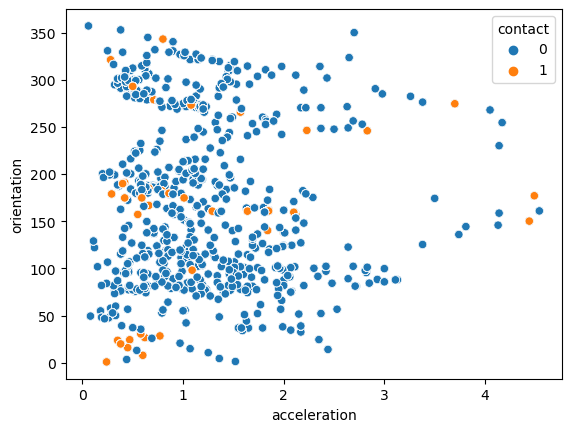

In [22]:
sns.scatterplot(data = track_labels_OT, x = 'acceleration', y= 'orientation', hue = 'contact')

## Same Merging for Player ID 2

In [23]:
train_player_tracking = train_player_tracking.rename({'nfl_player_id':'nfl_player_id_2'}, axis=1)

In [24]:
train_player_tracking['nfl_player_id_2']= train_player_tracking['nfl_player_id_2'].astype(str)

In [25]:
track_labels_player2 = pd.merge(train_labels, train_player_tracking, on = ['game_play','datetime','nfl_player_id_2'], how = 'inner')

In [26]:
track_labels_player2.head()

,contact_id,game_play,datetime,step_x,nfl_player_id,nfl_player_id_2,contact,game_key,play_id,step_y,...,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
0,58168_003392_0_38590_43854,58168_003392,2020-09-11T03:01:48.100Z,0,38590,43854,0,58168,3392,0,...,OLB,57,41.99,16.79,0.74,0.06,263.92,294.74,1.74,1.74
1,58168_003392_0_39947_43854,58168_003392,2020-09-11T03:01:48.100Z,0,39947,43854,0,58168,3392,0,...,OLB,57,41.99,16.79,0.74,0.06,263.92,294.74,1.74,1.74
2,58168_003392_0_42565_43854,58168_003392,2020-09-11T03:01:48.100Z,0,42565,43854,0,58168,3392,0,...,OLB,57,41.99,16.79,0.74,0.06,263.92,294.74,1.74,1.74
3,58168_003392_0_37084_43854,58168_003392,2020-09-11T03:01:48.100Z,0,37084,43854,0,58168,3392,0,...,OLB,57,41.99,16.79,0.74,0.06,263.92,294.74,1.74,1.74
4,58168_003392_0_40011_43854,58168_003392,2020-09-11T03:01:48.100Z,0,40011,43854,0,58168,3392,0,...,OLB,57,41.99,16.79,0.74,0.06,263.92,294.74,1.74,1.74


## Dataset with tracking and contact data for both players involved in each time step

In [27]:
track_labels_both_players = pd.merge(track_labels, track_labels_player2, on = ['game_play','datetime','contact_id','contact','game_key','play_id','nfl_player_id','nfl_player_id_2'], how = 'inner', suffixes =('_p1','_p2'))

In [28]:
track_labels_both_players.head()

,contact_id,game_play,datetime,step_x_p1,nfl_player_id,nfl_player_id_2,contact,game_key,play_id,step_y_p1,...,position_p2,jersey_number_p2,x_position_p2,y_position_p2,speed_p2,distance_p2,direction_p2,orientation_p2,acceleration_p2,sa_p2
0,58168_003392_0_38590_43854,58168_003392,2020-09-11T03:01:48.100Z,0,38590,43854,0,58168,3392,0,...,OLB,57,41.99,16.79,0.74,0.06,263.92,294.74,1.74,1.74
1,58168_003392_0_38590_41257,58168_003392,2020-09-11T03:01:48.100Z,0,38590,41257,0,58168,3392,0,...,CB,21,45.77,15.59,0.67,0.07,180.38,270.88,0.34,0.08
2,58168_003392_0_38590_41944,58168_003392,2020-09-11T03:01:48.100Z,0,38590,41944,0,58168,3392,0,...,DT,92,42.00,22.85,0.68,0.08,234.17,282.07,0.81,0.81
3,58168_003392_0_38590_42386,58168_003392,2020-09-11T03:01:48.100Z,0,38590,42386,0,58168,3392,0,...,ILB,55,45.87,23.89,0.61,0.06,221.19,269.45,1.11,1.10
4,58168_003392_0_38590_47944,58168_003392,2020-09-11T03:01:48.100Z,0,38590,47944,0,58168,3392,0,...,DE,94,42.10,26.58,0.20,0.03,240.11,266.04,1.63,1.23


## Create new columns that describe relativity between player 1 and player 2 on the each time step

ex: 'y_position_rel' would describe the y_position of player 1 relative to player 2

In [29]:
def create_relative_col(p1col, p2col):
    track_labels_both_players[p1col+'_rel']= track_labels_both_players[p1col] - track_labels_both_players[p2col]

In [30]:
track_labels_both_players.columns

Index(['contact_id', 'game_play', 'datetime', 'step_x_p1', 'nfl_player_id',
       'nfl_player_id_2', 'contact', 'game_key', 'play_id', 'step_y_p1',
       'team_p1', 'position_p1', 'jersey_number_p1', 'x_position_p1',
       'y_position_p1', 'speed_p1', 'distance_p1', 'direction_p1',
       'orientation_p1', 'acceleration_p1', 'sa_p1', 'step_x_p2', 'step_y_p2',
       'team_p2', 'position_p2', 'jersey_number_p2', 'x_position_p2',
       'y_position_p2', 'speed_p2', 'distance_p2', 'direction_p2',
       'orientation_p2', 'acceleration_p2', 'sa_p2'],
      dtype='object')

In [31]:
cols_for_relative = rel_col_array = [['x_position_p1','x_position_p2'], ['speed_p1','speed_p2'], ['y_position_p1','y_position_p2'],
                     ['distance_p1','distance_p2'], ['direction_p1','direction_p2'], ['orientation_p1','orientation_p2'],
                     ['acceleration_p1','acceleration_p2'], ['sa_p1','sa_p2']]

In [32]:
for measure in rel_col_array:
    create_relative_col(measure[0],measure[1])

In [33]:
track_labels_both_players.columns

Index(['contact_id', 'game_play', 'datetime', 'step_x_p1', 'nfl_player_id',
       'nfl_player_id_2', 'contact', 'game_key', 'play_id', 'step_y_p1',
       'team_p1', 'position_p1', 'jersey_number_p1', 'x_position_p1',
       'y_position_p1', 'speed_p1', 'distance_p1', 'direction_p1',
       'orientation_p1', 'acceleration_p1', 'sa_p1', 'step_x_p2', 'step_y_p2',
       'team_p2', 'position_p2', 'jersey_number_p2', 'x_position_p2',
       'y_position_p2', 'speed_p2', 'distance_p2', 'direction_p2',
       'orientation_p2', 'acceleration_p2', 'sa_p2', 'x_position_p1_rel',
       'speed_p1_rel', 'y_position_p1_rel', 'distance_p1_rel',
       'direction_p1_rel', 'orientation_p1_rel', 'acceleration_p1_rel',
       'sa_p1_rel'],
      dtype='object')

## Filter for all instances involving OTs

In [34]:
track_labels_OT_D = track_labels_both_players.query("position_p1 == 'T' or position_p1 == 'OT'")

In [35]:
len(track_labels_both_players[track_labels_both_players['position_p1']=='T'])

8309

## Use Histograms to show which relative stats give insight into where contact occurs

<AxesSubplot:xlabel='x_position_p1_rel', ylabel='Count'>

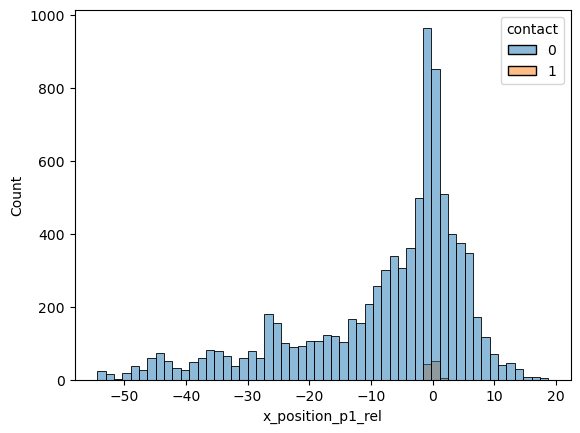

In [36]:
sns.histplot(data = track_labels_OT_D, x = 'x_position_p1_rel', hue = 'contact')

<AxesSubplot:xlabel='orientation_p1_rel', ylabel='Count'>

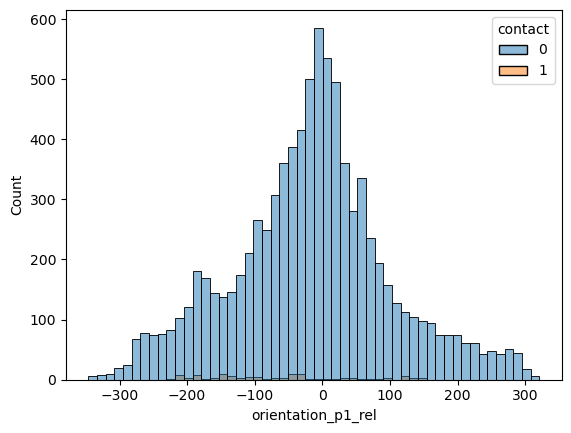

In [37]:
sns.histplot(data = track_labels_OT_D, x = 'orientation_p1_rel', hue = 'contact')

<AxesSubplot:xlabel='speed_p1_rel', ylabel='Count'>

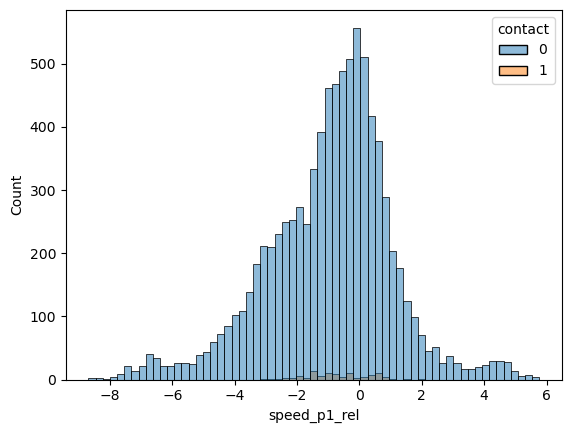

In [38]:
sns.histplot(data = track_labels_OT_D, x = 'speed_p1_rel', hue = 'contact')

<AxesSubplot:xlabel='distance_p1_rel', ylabel='Count'>

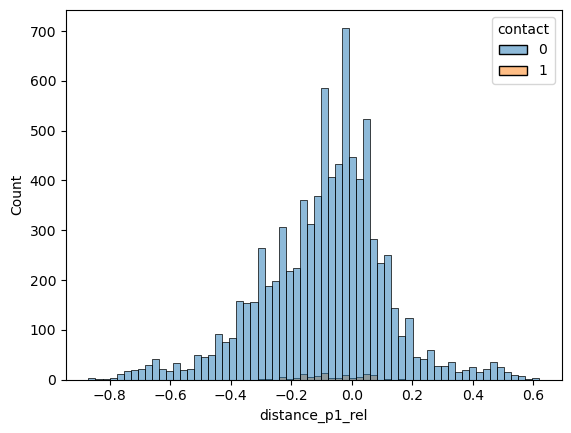

In [39]:
sns.histplot(data = track_labels_OT_D, x = 'distance_p1_rel', hue = 'contact')

<AxesSubplot:xlabel='direction_p1_rel', ylabel='Count'>

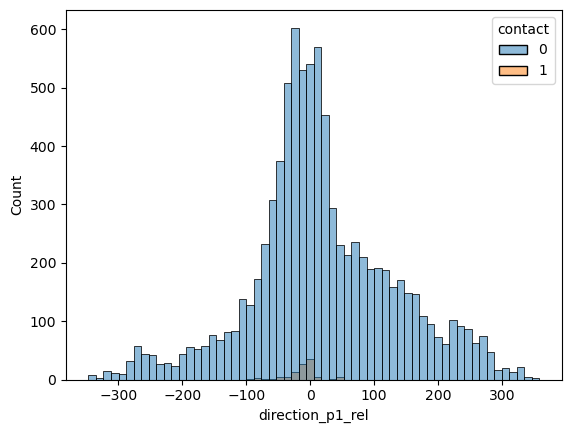

In [40]:
sns.histplot(data = track_labels_OT_D, x = 'direction_p1_rel', hue = 'contact')

<AxesSubplot:xlabel='sa_p1_rel', ylabel='Count'>

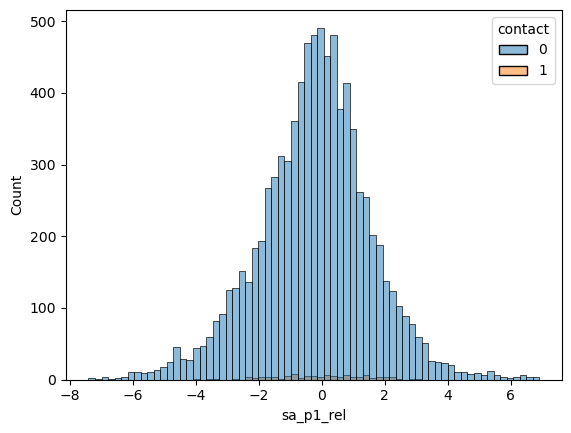

In [41]:
sns.histplot(data = track_labels_OT_D, x = 'sa_p1_rel', hue = 'contact')

<AxesSubplot:xlabel='orientation_p1_rel', ylabel='distance_p1_rel'>

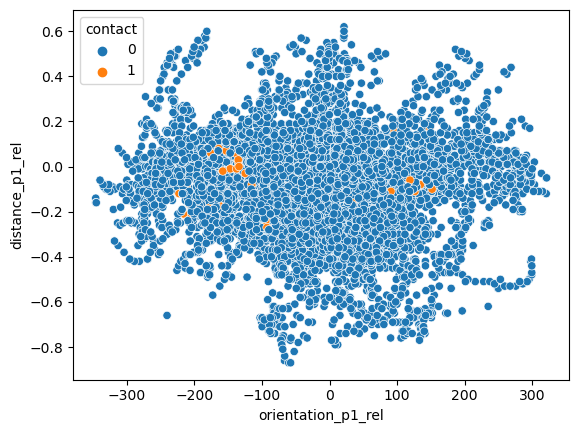

In [42]:
sns.scatterplot(data = track_labels_OT_D, x = 'orientation_p1_rel', y= 'distance_p1_rel', hue='contact')

Seems like the relative orientations of around -200 or 100 between player 1 and player 1 are good indicators of contact occurring.

Additionally, relative direction is usually around 0 where Offensive Tackle contact occurs, and relative distance traveled is usually between 0 and -1

## Fitting Random Forest Model to predict Offensive Tackle Contact

Using the features listed above, I fitted a random forest model to predict contact. I used a max features of 1, meaning that each decision tree created used only 1 of the 3 features. All the decision trees created averaged out to create the final model 

In [43]:
from sklearn.ensemble import RandomForestRegressor
X_cols = ['orientation_p1_rel', 'direction_p1_rel', 'distance_p1_rel']
forest_model = RandomForestRegressor(max_features=1)

forest_model.fit(X = track_labels_OT_D[X_cols], y= track_labels_OT_D['contact'])
track_labels_OT_D["RF_pred"] = forest_model.predict(track_labels_OT_D[X_cols])

/tmp/ipykernel_96/1366888835.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_labels_OT_D["RF_pred"] = forest_model.predict(track_labels_OT_D[X_cols])


create column with the contact / no-contact predictions for each time stamp :

In [44]:
track_labels_OT_D['rounded_RF_pred'] = np.round(track_labels_OT_D['RF_pred'],0)

/tmp/ipykernel_96/4011318206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_labels_OT_D['rounded_RF_pred'] = np.round(track_labels_OT_D['RF_pred'],0)


In [45]:
track_labels_OT_D['rounded_RF_pred'].value_counts()

0.0    8631
1.0      98
Name: rounded_RF_pred, dtype: int64

What's the fraction of predictions that were incorrect?:

In [46]:
train_accuracy = np.mean((track_labels_OT_D["RF_pred"] - track_labels_OT_D["contact"]))
train_accuracy

-0.00034711879940428457

## Create DF of all predicted contacts from the RF model, and plot histograms to see where these *predicted* contacts occur across orientation, direction, distance

In [49]:
predicted_contact_observations = track_labels_OT_D[track_labels_OT_D['rounded_RF_pred'] == 1.0]

(array([0.00340627, 0.00327001, 0.00367877, 0.00122626, 0.00177126]),
 array([-222.83 , -147.938,  -73.046,    1.846,   76.738,  151.63 ]),
 <BarContainer object of 5 artists>)

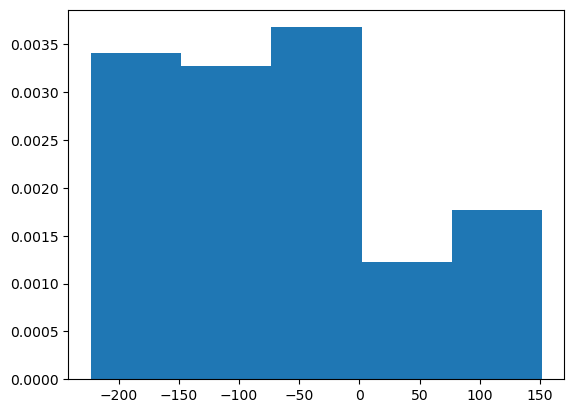

In [51]:
plt.hist(predicted_contact_observations['orientation_p1_rel'], density = True, bins = 5)

(array([0.00143618, 0.00215427, 0.0125666 , 0.0172342 , 0.00179523]),
 array([-93.89, -65.47, -37.05,  -8.63,  19.79,  48.21]),
 <BarContainer object of 5 artists>)

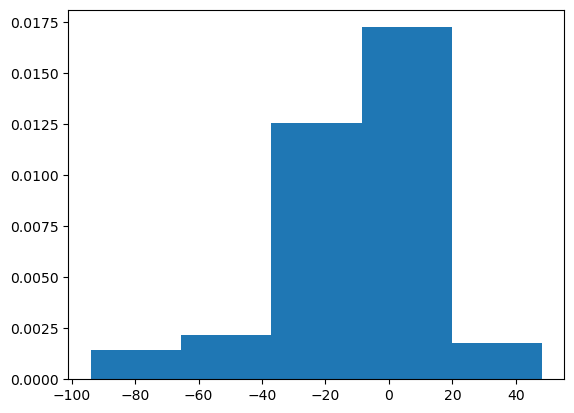

In [52]:
plt.hist(predicted_contact_observations['direction_p1_rel'], density = True, bins = 5)

(array([0.99822538, 2.99467613, 3.21650399, 2.77284827, 0.88731145]),
 array([-0.29 , -0.198, -0.106, -0.014,  0.078,  0.17 ]),
 <BarContainer object of 5 artists>)

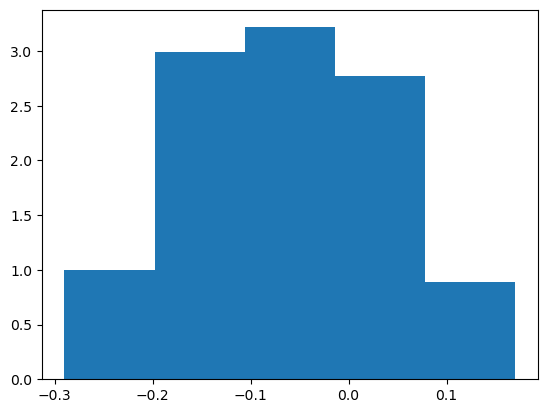

In [53]:
plt.hist(predicted_contact_observations['distance_p1_rel'], density = True, bins = 5)

Given probability of OT contact occuring given these specific inputs of orientation, direction, distance

In [54]:
forest_model.predict([[-200, 1, -.05]])

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.61])

In [55]:
track_labels_both_players['game_play'].value_counts()

58173_003606    30030
58172_003247    29106
58168_003392    16170
58174_001792    15982
Name: game_play, dtype: int64

## Download images from the plays that are in our dataset

In [56]:
pip install opencv-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [57]:
import cv2 as cv

In [58]:
vidcap = cv.VideoCapture('58168_003392_Endzone.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [59]:
vidcap = cv.VideoCapture('58172_003247_Endzone.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv.imwrite("frame%d -2.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  #print('Read a new frame: ', success)
  count += 1

In [60]:
vidcap = cv.VideoCapture('58173_003606_Endzone.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv.imwrite("frame%d -3.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  #print('Read a new frame: ', success)
  count += 1

In [62]:
vidcap = cv.VideoCapture('58174_001792_Endzone.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv.imwrite("frame%d -4.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  #print('Read a new frame: ', success)
  count += 1

## Get Video Metadata Dataframe for plays in our tracking/contact dataset

In [60]:
train_video_metadata = pd.read_csv('train_video_metadata.csv')

In [57]:
game_plays = ['58173_003606', '58172_003247', '58168_003392', '58174_001792']

In [61]:
metadata_plays = train_video_metadata[train_video_metadata['game_play'].isin(game_plays)]

In [62]:
first_play_metadata = metadata_plays[metadata_plays['game_play'] == '58173_003606']

In [63]:
metadata_plays

,game_play,game_key,play_id,view,start_time,end_time,snap_time
0,58168_003392,58168,3392,Endzone,2020-09-11T03:01:43.134Z,2020-09-11T03:01:54.971Z,2020-09-11T03:01:48.134Z
1,58168_003392,58168,3392,Sideline,2020-09-11T03:01:43.134Z,2020-09-11T03:01:54.971Z,2020-09-11T03:01:48.134Z
2,58172_003247,58172,3247,Endzone,2020-09-13T19:30:42.414Z,2020-09-13T19:31:00.524Z,2020-09-13T19:30:47.414Z
3,58172_003247,58172,3247,Sideline,2020-09-13T19:30:42.414Z,2020-09-13T19:31:00.524Z,2020-09-13T19:30:47.414Z
4,58173_003606,58173,3606,Endzone,2020-09-13T19:45:07.527Z,2020-09-13T19:45:26.438Z,2020-09-13T19:45:12.527Z
5,58173_003606,58173,3606,Sideline,2020-09-13T19:45:07.527Z,2020-09-13T19:45:26.438Z,2020-09-13T19:45:12.527Z
6,58174_001792,58174,1792,Endzone,2020-09-13T18:11:38.532Z,2020-09-13T18:11:51.415Z,2020-09-13T18:11:43.532Z
7,58174_001792,58174,1792,Sideline,2020-09-13T18:11:38.532Z,2020-09-13T18:11:51.415Z,2020-09-13T18:11:43.532Z


In [67]:
OTs_game3 = track_labels_OT_D[track_labels_OT_D['game_play'] == '58173_003606']

In [68]:
OTs_game3.groupby('datetime').size()

datetime
2020-09-13T19:45:12.500Z    37
2020-09-13T19:45:12.600Z    37
2020-09-13T19:45:12.700Z    37
2020-09-13T19:45:12.800Z    37
2020-09-13T19:45:12.900Z    37
                            ..
2020-09-13T19:45:25.000Z    37
2020-09-13T19:45:25.100Z    37
2020-09-13T19:45:25.200Z    37
2020-09-13T19:45:25.300Z    37
2020-09-13T19:45:25.400Z    37
Length: 130, dtype: int64

In [69]:
OTs_game3.groupby('datetime')['contact'].mean()

datetime
2020-09-13T19:45:12.500Z    0.0
2020-09-13T19:45:12.600Z    0.0
2020-09-13T19:45:12.700Z    0.0
2020-09-13T19:45:12.800Z    0.0
2020-09-13T19:45:12.900Z    0.0
                           ... 
2020-09-13T19:45:25.000Z    0.0
2020-09-13T19:45:25.100Z    0.0
2020-09-13T19:45:25.200Z    0.0
2020-09-13T19:45:25.300Z    0.0
2020-09-13T19:45:25.400Z    0.0
Name: contact, Length: 130, dtype: float64

## Using Regex to Extract the Seconds of the Chosen Play, and Put it Into a Column 
###  - This is done to extract the labels for each frame of our play. Each frame (.jpg files that we saved) needs to be labeled as OT contact or no OT contact in order to train the Computer vision Neural Net to identify contact

In [70]:
pat = r'.*:(\d+\.\d+)Z'
#OTs_game3['datetime'].str.findall(pat)
type((OTs_game3['datetime'].str.extractall(pat))[0].astype(float))

pandas.core.series.Series

In [71]:
OTs_game3['seconds'] = OTs_game3.datetime.str.extract(pat).astype(float)

/tmp/ipykernel_96/3869505256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OTs_game3['seconds'] = OTs_game3.datetime.str.extract(pat).astype(float)


check that the minimum second is the snap time :

In [72]:
np.min(OTs_game3['seconds'])

12.5

In [73]:
OTs_game3['seconds']

45291    21.1
45292    21.1
45293    21.1
45294    21.1
45295    21.1
         ... 
75236    16.8
75237    16.8
75238    16.8
75239    16.8
75240    16.8
Name: seconds, Length: 4810, dtype: float64

now that we have a function that extracts the second from the dataframe using regex, we can go about labeling each frame that we have...
we need to write a group of functions that work together to :
    - create a filtered dataframe of tracking/labels in the second

## In order to get a contact label 

In [1]:
def change_top_of_minute_sec(float):
    """
    Argument (float) : extracted second in a row of the datetime column of our full track/labels OT dataset
    
    Returns : if the second is less than one, 
    then a new minute as elapsed (ex: 2 min 59 sec to 3 min 1 sec), 
    and we set the second to 60 to be able to take the difference between seconds still
    """
    if float < 1:
        return 60
    else:
        return float

In [3]:
def labels_for_second(df):
    """
    Arg (pd.DataFrame) : The dataframe that contains the tracking/labeling data for a particular second in the play
    
    Returns : A 2-D list of contact labels (0 or 1 int) 
    that contains each row as a second in the play and each column as the label for a particular frame in that play
    
    """
    labels = []
    length = len(df)
    # since there are 60 frames per second of the play, each interval has to be 1/60th of the contact data. 
    # that way, each label contains the contact data from that interval, and we have a contact /ground truth for each frame
    
    interval = length/60
    i = 0
    j=0+ int(np.floor(interval))
    while j <= (length -1):
        label = df['contact'][i:j].mean()
        if label > 0:
            label = 1
        else:
            label = 0
        labels.append(label)
        i+=int(interval)
        j+=int(interval)
    return labels

In [1]:
def df_for_second(game_df, second):
    """
    Args: game_df - Data Frame of the play we want, second - the second of the play we want to get the frames from
    Returns: A dataframe of the OT contact data from that second 
    """
    snap_time = np.min(game_df['seconds'])
    this_second_df = game_df[(game_df['seconds']>=snap_time+second) & (game_df['seconds']<=(snap_time+second+1))]
    return this_second_df

In [2]:
def game_df_sec_col(game_play):
    """
    Arg(string): The game_play identifier for the play we want 
    Returns: DataFrame with OT contact data with the seconds column added
    """

    OTs_game_df = track_labels_OT_D[track_labels_OT_D['game_play'] == game_play]
    pat = r'.*:(\d+\.\d+)Z'
    OTs_game_df['seconds'] = OTs_game_df.datetime.str.extract(pat).astype(float)
    if len(OTs_game_df.query("seconds < 1")) >=1:
        OTs_game_df['seconds'] = OTs_game_df['seconds'].map(change_top_of_minute_sec)
    return OTs_game_df

In [86]:
def find_all_labels_for_play(game_play):
    """
    Arg(string): The game_play identifier for the play we want
    Returns : 3-d array which contains the labels for each second at each index
    """
    all_sec_labels = []
    game_df = game_df_sec_col(game_play)
    snap_time = np.min(game_df['seconds'])
    end_time = np.max(game_df['seconds'])
    for s in range(0, int(np.ceil(end_time-snap_time))+1):
        sec_df = df_for_second(game_df,s)
        sec_labels = labels_for_second(sec_df)
        all_sec_labels.append(sec_labels)
        
    return all_sec_labels

## Consolidate all the labels from each second of a given play into one array

In [94]:
first_sec_labs = all_lab_pl1[0]
for i in range(1,7):
    first_sec_labs.extend(all_lab_pl1[i])

In [95]:
len(first_sec_labs)

438

In [96]:
all_labs_p1 = first_sec_labs

In [97]:
all_labs_p1[0:20]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

### truncate the labels for this play to match the number of frames in the play

In [98]:
all_labs_p1 = all_labs_p1[0:409]

In [100]:
all_lab_pl3 = find_all_labels_for_play('58173_003606')

/tmp/ipykernel_96/1191573112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OTs_game_df['seconds'] = OTs_game_df.datetime.str.extract(pat).astype(float)


In [101]:
len(all_lab_pl3)

14

In [102]:
first_sec_labs3 = all_lab_pl3[0]
for i in range(1,13):
    first_sec_labs3.extend(all_lab_pl3[i])

In [103]:
all_labs_p3 = first_sec_labs3

In [104]:
len(all_labs_p3)

865

In [106]:
all_labs_p3 = all_labs_p3[0:832]

### shape of each frame

In [107]:
from PIL import Image
frame_10_pl3 = np.array(Image.open('frame10 -3.jpg'))
frame_10_pl3.shape

(720, 1280, 3)

### read the frames of the videos into skvideo which transforms it into an array

In [ ]:
import skvideo.io  
video1data = skvideo.io.vread("58168_003392_Endzone.mp4")  
video3data = skvideo.io.vread("58173_003606_Endzone.mp4")

In [108]:
pip install torchvision

  Using cached torchvision-0.15.2-cp39-cp39-manylinux1_x86_64.whl (6.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [109]:
import torch
from torch import nn
import torchvision
from torchvision import transforms 
from torchvision.transforms import ToTensor

ModuleNotFoundError: No module named 'torch'

### Download helper functions that visualize the accuracy of our image predictions for whether OT contact occured

In [ ]:
import requests 
from pathlib import Path

if Path("helper_fuctions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Download helper functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

In [ ]:
## OT contact Neural Network:
    ## input: The image.. shaped (720, 1280, 3) - flattened shape is 921600. flattened shape allows the image to be a NN input layer
    ## hidden units: how many hidden units in the hidden layer... essentially gives the model more chances to find elements of the image to use for classification
    ##  layer_stack stacks the layers of hidden units 
    ## ReLU - each layer contains nonlinear function in order to help the model compress 
            ## certain areas of pixels in order to make it linearly separable (patterns more easily identified)
class OTContactModel(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                  out_features= hidden units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                  out_features= output_shape),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

### instantiate the model

In [ ]:
model_0 = OTContactModel(input_shape=921600,
                              hidden_units=40,
                              output_shape=1

### specify loss function used to evaluate the accuracy of the contact predictions... BCE loss allows the parameters to shift based on the degree to which predictions for whether contact occurred are incorrect

### specify Gradient Descent method which is what uses the loss to move the parameters for the next training epoch

In [ ]:
loss_fn = nn.BinaryCrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=.1)

In [ ]:
plays_arrays = [video1data, video3data]

### train the data

In [ ]:
from tqdm.auto import tqdm
#torch.manual_seed(42)
train_start_time_on_cpu = timer()

#specify number of epochs
epochs = 3
#iterate through epochs
for eponch in tqdm(range(epochs)):
  train_loss = 0

# for first play, the training play, iterate through the arrays (frames), pass the frame into the model
    # with the ground truth as the image contact label and the array as the model input which predicts contact
  for i in range(0,len(plays_arrays[1])):
    model_0.train()
    y = all_labs_p3[i]
    y_pred = model_0(plays_arrays[1][i])
    #calculate BCE loss for the frame
    loss = loss_fn(y_pred, y)
    #accumulate loss with each frame
    train_loss += loss

    #shift parameters according to loss
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #if batch % 400 == 0:
      #print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")

        #calculate loss per frame in this epoch
  train_loss /= len(plays_arrays[1])

  test_loss, test_acc = 0,0
    # evaluate predictions for contact/noncontact on the test play
  model_0.eval()
  with torch.inference_mode():
        #for each frame, get the prediction and loss
    for i in range(0,len(plays_arrays[0])):
      test_pred = model_0(plays_arrays[0][i])
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
# get loss per frame 
    test_loss /= len(plays_arrays[0])
    test_acc /= len(plays_arrays[0])

  print(f"\nTrain Loss: {train_loss: .4f} | Test Loss : {test_loss: .4f}, Test acc: {test_acc: .4f}")

train_end_time_on_cpu = timer()
total_train_time_model_0 = print_train_time(start= train_start_time_on_cpu,
                                                end= train_end_time_on_cpu,
                                                device= str(next(model_0.parameters())))
    

## Conclusion

The above project was an attempt at training a random forest model to recognize offensive tackle prospect points of contact, using variables such as:
- Orientation Difference : diff between orientation of Tackle to a defensive player
- Distance : distance between tackle and a defensive player
- Relative direction of movement between tackle and def player

It may seem trivial and obvious that less distance and opposite movement equates to contact, but this ,model could be leveraged in a dataset that also contains a binary column with injury data.

The model uses data from a few games in the 2021 season.

Then image arrays were constructed from the video files given, and a computer vision model was constructed to identify OT contact in a frame 

Due to memory constraints, given that each frame consists of 921600 pixels, the images couldn't be stored as arrays

The hope is that the model could be fine tuned to minimize error by expirimenting with ReLU and Pooling layers, optimizing the performance of the AI